<a href="https://colab.research.google.com/github/MoRebaie/Sequences-Time-Series-Prediction-in-Tensorflow/blob/master/Course_4_Week_4_Lesson_5b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

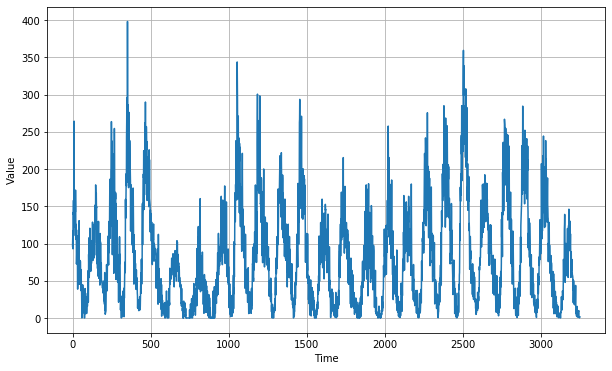

In [4]:
import csv
time_step = []
sunspots = []

with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

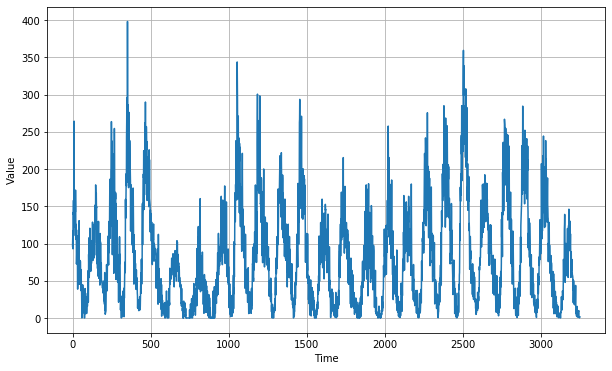

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 552ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 3s 251ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 3s 268ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 3s 253ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 3s 248ms/step - loss: 68.5303 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 3s 262ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 3s 288ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 3s 289ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 3s 272ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 3s 281ms/step - loss: 23.4105 - mae: 24.8199
Epoch 83/100
12/12 [==============================] - 3s 280ms/step - loss: 32.2223 - mae: 32.7575
Epoch 84/100
12/12 [==============================] - 3s 286ms/step - loss: 27.3758 - mae: 27.8569
Epoch 85/100
12/12 [==============================] - 3s 291ms/step - loss: 28.2014 - mae: 28.7715
Epoch 86/100
12/12 [==============================] - 3s 285ms/step - loss: 33.7510 - mae: 34.0702
Epoch 87/100
12/12 [==============================] - 3s 280ms/step - loss: 32.2405 - mae: 32.8612
Epoch 88/100
12/12 [==============================] - 3s 280ms/step - loss: 40.4057 - mae: 40.4310
Epoch 89/100
12/12 [==============================] - 3s 285ms/step - loss: 29.5379 - mae: 29.8389
Epoch 90/100
12/12 [==============================] - 3s 290ms/step - loss: 55.6631 - mae: 55.8453
Epoch 91/100
12/12 [==============================] - 3s 288ms/step - loss: 47.3559 - mae: 47.3795
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

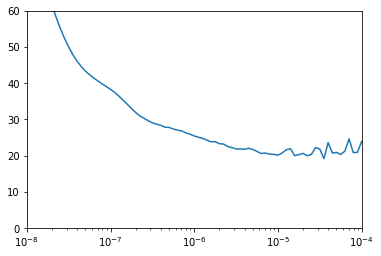

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 200ms/step - loss: 37.8898 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 3s 95ms/step - loss: 24.1475 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 3s 98ms/step - loss: 22.0298 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 3s 104ms/step - loss: 19.8086 - mae: 20.3076
Epoch 5/500
30/30 [==============================] - 3s 98ms/step - loss: 19.4430 - mae: 19.9379
Epoch 6/500
30/30 [==============================] - 3s 96ms/step - loss: 19.2403 - mae: 19.7291
Epoch 7/500
30/30 [==============================] - 3s 96ms/step - loss: 18.5770 - mae: 19.0837
Epoch 8/500
30/30 [==============================] - 3s 98ms/step - loss: 18.5266 - mae: 19.0043
Epoch 9/500
30/30 [==============================] - 3s 98ms/step - loss: 18.1933 - mae: 18.7109
Epoch 10/500
30/30 [==============================] - 3s 97ms/step - loss: 18.1212 - mae: 18.6238
Epoch 11/500
30/30 [=======

Epoch 84/500
30/30 [==============================] - 3s 117ms/step - loss: 16.4222 - mae: 16.9166
Epoch 85/500
30/30 [==============================] - 3s 116ms/step - loss: 16.4673 - mae: 16.9609
Epoch 86/500
30/30 [==============================] - 3s 115ms/step - loss: 16.3652 - mae: 16.8628
Epoch 87/500
30/30 [==============================] - 4s 119ms/step - loss: 16.6144 - mae: 17.1192
Epoch 88/500
30/30 [==============================] - 4s 128ms/step - loss: 16.5243 - mae: 17.0394
Epoch 89/500
30/30 [==============================] - 4s 127ms/step - loss: 16.3981 - mae: 16.8852
Epoch 90/500
30/30 [==============================] - 4s 120ms/step - loss: 16.5498 - mae: 17.0293
Epoch 91/500
30/30 [==============================] - 4s 123ms/step - loss: 16.3579 - mae: 16.8518
Epoch 92/500
30/30 [==============================] - 4s 139ms/step - loss: 16.2935 - mae: 16.7949
Epoch 93/500
30/30 [==============================] - 4s 135ms/step - loss: 16.2964 - mae: 16.7935
Epoch 94/5

30/30 [==============================] - 5s 171ms/step - loss: 16.0366 - mae: 16.5150
Epoch 167/500
30/30 [==============================] - 5s 177ms/step - loss: 15.7844 - mae: 16.2777
Epoch 168/500
30/30 [==============================] - 5s 179ms/step - loss: 15.7918 - mae: 16.2915
Epoch 169/500
30/30 [==============================] - 5s 173ms/step - loss: 15.7841 - mae: 16.2818
Epoch 170/500
30/30 [==============================] - 5s 173ms/step - loss: 15.7851 - mae: 16.2690
Epoch 171/500
30/30 [==============================] - 5s 172ms/step - loss: 15.8365 - mae: 16.3323
Epoch 172/500
30/30 [==============================] - 5s 174ms/step - loss: 15.7452 - mae: 16.2377
Epoch 173/500
30/30 [==============================] - 5s 178ms/step - loss: 15.8158 - mae: 16.2964
Epoch 174/500
30/30 [==============================] - 5s 176ms/step - loss: 15.7507 - mae: 16.2401
Epoch 175/500
30/30 [==============================] - 5s 173ms/step - loss: 15.8284 - mae: 16.3189
Epoch 176/500


30/30 [==============================] - 5s 159ms/step - loss: 15.3733 - mae: 15.8742
Epoch 249/500
30/30 [==============================] - 5s 169ms/step - loss: 15.3769 - mae: 15.8843
Epoch 250/500
30/30 [==============================] - 5s 157ms/step - loss: 15.4105 - mae: 15.8965
Epoch 251/500
30/30 [==============================] - 5s 161ms/step - loss: 15.2945 - mae: 15.7606
Epoch 252/500
30/30 [==============================] - 5s 159ms/step - loss: 15.3485 - mae: 15.8263
Epoch 253/500
30/30 [==============================] - 5s 159ms/step - loss: 15.2931 - mae: 15.7805
Epoch 254/500
30/30 [==============================] - 5s 158ms/step - loss: 15.2647 - mae: 15.7563
Epoch 255/500
30/30 [==============================] - 5s 160ms/step - loss: 15.2766 - mae: 15.7368
Epoch 256/500
30/30 [==============================] - 5s 160ms/step - loss: 15.2707 - mae: 15.7588
Epoch 257/500
30/30 [==============================] - 5s 166ms/step - loss: 15.2811 - mae: 15.7858
Epoch 258/500


30/30 [==============================] - 5s 162ms/step - loss: 15.0212 - mae: 15.5032
Epoch 331/500
30/30 [==============================] - 5s 161ms/step - loss: 14.9254 - mae: 15.4027
Epoch 332/500
30/30 [==============================] - 5s 156ms/step - loss: 14.9155 - mae: 15.3941
Epoch 333/500
30/30 [==============================] - 5s 153ms/step - loss: 14.9124 - mae: 15.3939
Epoch 334/500
30/30 [==============================] - 5s 159ms/step - loss: 14.8317 - mae: 15.3285
Epoch 335/500
30/30 [==============================] - 5s 158ms/step - loss: 14.8803 - mae: 15.3575
Epoch 336/500
30/30 [==============================] - 5s 158ms/step - loss: 14.8438 - mae: 15.3355
Epoch 337/500
30/30 [==============================] - 5s 164ms/step - loss: 14.9365 - mae: 15.4286
Epoch 338/500
30/30 [==============================] - 5s 161ms/step - loss: 14.9680 - mae: 15.4328
Epoch 339/500
30/30 [==============================] - 5s 155ms/step - loss: 14.8504 - mae: 15.3548
Epoch 340/500


30/30 [==============================] - 3s 113ms/step - loss: 14.5310 - mae: 15.0252
Epoch 413/500
30/30 [==============================] - 3s 109ms/step - loss: 14.5423 - mae: 15.0275
Epoch 414/500
30/30 [==============================] - 3s 109ms/step - loss: 14.4394 - mae: 14.9247
Epoch 415/500
30/30 [==============================] - 3s 115ms/step - loss: 14.5352 - mae: 15.0248
Epoch 416/500
30/30 [==============================] - 3s 115ms/step - loss: 14.6720 - mae: 15.1667
Epoch 417/500
30/30 [==============================] - 3s 112ms/step - loss: 14.4827 - mae: 14.9567
Epoch 418/500
30/30 [==============================] - 3s 110ms/step - loss: 14.3706 - mae: 14.8577
Epoch 419/500
30/30 [==============================] - 3s 109ms/step - loss: 14.7143 - mae: 15.1801
Epoch 420/500
30/30 [==============================] - 3s 111ms/step - loss: 14.3459 - mae: 14.8240
Epoch 421/500
30/30 [==============================] - 3s 115ms/step - loss: 14.6048 - mae: 15.1031
Epoch 422/500


30/30 [==============================] - 3s 111ms/step - loss: 14.1301 - mae: 14.6033
Epoch 495/500
30/30 [==============================] - 3s 111ms/step - loss: 14.2169 - mae: 14.6963
Epoch 496/500
30/30 [==============================] - 3s 114ms/step - loss: 14.0011 - mae: 14.5052
Epoch 497/500
30/30 [==============================] - 3s 115ms/step - loss: 14.1231 - mae: 14.6241
Epoch 498/500
30/30 [==============================] - 3s 113ms/step - loss: 14.1958 - mae: 14.6940
Epoch 499/500
30/30 [==============================] - 3s 111ms/step - loss: 14.3917 - mae: 14.8654
Epoch 500/500
30/30 [==============================] - 3s 111ms/step - loss: 14.1773 - mae: 14.6765


In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

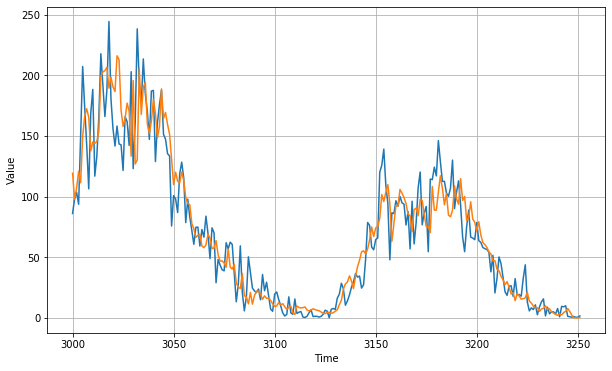

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.619851

<Figure size 432x288 with 0 Axes>

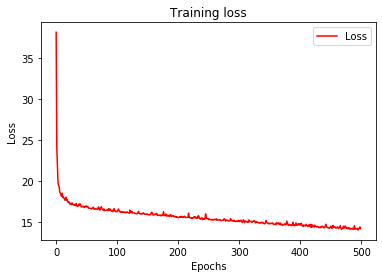

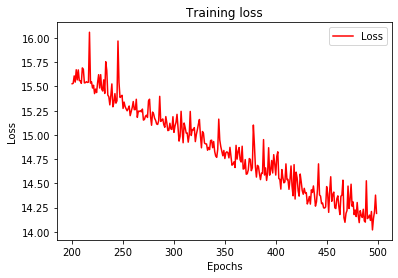

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [20]:
print(rnn_forecast)

[128.34058   117.36959   120.21221   132.9964    119.64408   152.58786
 181.13803   185.29076   173.63475   132.6062    150.20526   160.88815
 163.61447   171.61197   211.39217   221.32239   224.66443   214.8448
 191.54178   192.60901   189.11853   191.98352   214.38405   212.87851
 166.91495   156.36555   155.82523   178.84999   175.02908   140.73271
 196.68854   131.36443   126.95976   204.3727    150.5691    162.80179
 174.71324   140.41599   139.38342   147.95525   176.58795   175.7258
 165.33727   162.73628   193.00378   171.122     171.76006   161.18188
 162.52214   134.54166   109.517654  123.663284  112.04064   109.65196
 113.83678   112.192474  103.10232    97.70291    94.381096   77.466324
  71.36468    66.25992    70.35916    69.88442    61.27887    61.12542
  62.034565   70.3916     68.30441    58.10794    59.131485   63.385876
  51.6235     46.63688    45.235954   45.366383   39.75632    53.87586
  41.329395   40.827908   42.400898   30.238804   24.05354    24.577883
  38.